## Predicting Probability of Water Hyacinth from Satellite Radar Imagery¶

Imports and Read Data


In [1]:
import pandas as pd
import numpy as np
import os
import enum
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
# from visuals import plot_examples, plot_3d_example
import matplotlib.gridspec as gridspec
import plotly.graph_objs as go
import plotly.offline as py
%matplotlib inline
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, Dropout, Flatten, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten, Dense



py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# here is where you save your images
datafolder=r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\STK'

# list of convenience
bands = ['VV', 'VH', 'VV/VH']
print('bands:',bands)
#%% Loading the images
#[C11, C22_full, C12] = np.load(path_save + 'filename.npy')
images_orig=np.load(datafolder + '\TrainingData_Vembanadlake_64.npy')
print('Reading pre-stored stack of patches...',images_orig.shape)    

category_names = [
 'clean water',
 'infested water']


# load all data
N_images = 16  # per category
nb_classes = 2
patch_size = 64  # width and height in pixel
channels = 3
nb_images = N_images * nb_classes

a=np.array(np.ones([16,1],'int')) #infested water
b=np.array(np.zeros([16,1],'int'))#clean water
labels=np.array(np.vstack((a,b)))





bands: ['VV', 'VH', 'VV/VH']
Reading pre-stored stack of patches... (32, 64, 64, 3)


# Package and Scale radar bands into 4D tensors¶


We normalize each band for each image, essentially hoping that each image's decibel's levels can be normalized sufficently.


In [3]:
#shuffle
shuffled_indices = np.arange(nb_images)
np.random.seed(0)
np.random.shuffle(shuffled_indices)

training_indices = shuffled_indices[:int(0.7*nb_images)]               # 70% for training
val_indices = shuffled_indices[int(0.7*nb_images):int(0.8*nb_images)]  # 10% for val
test_indices = shuffled_indices[int(0.8*nb_images):]                   # 20% for test

training_images = images_orig[training_indices]
val_images = images_orig[val_indices]
test_images = images_orig[test_indices]

#transpose
#training_images = np.transpose(training_images, (0, 3, 1, 2))
#val_images = np.transpose(val_images, (0, 3, 1, 2))
#test_images = np.transpose(test_images, (0, 3, 1, 2))

#split
training_labels = labels[training_indices]
val_labels = labels[val_indices]
test_labels = labels[test_indices]

In [4]:


print(training_images.shape)
print(test_images.shape)



(22, 64, 64, 3)
(7, 64, 64, 3)


# Visualize Radar Images

All visualizations are plotted using HH Band 1.


In [5]:
#Reshape input data - Tensorflow likes TENSORS!
X_train = training_images[:,:,:, 1]
X_test = test_images[:,:,:, 1]

print('Train data shape {}'.format(X_train.shape))

Train data shape (22, 64, 64)


In [6]:
X_train = X_train.reshape(training_images.shape[0], 64,64, 1)
X_test = X_test.reshape(test_images.shape[0], 64,64, 1)

print('Train data shape {}'.format(X_train.shape))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


Train data shape (22, 64, 64, 1)


C:\Users\vaak\Anaconda3\envs\snappy\lib\site-packages\matplotlib\text.py:1165: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



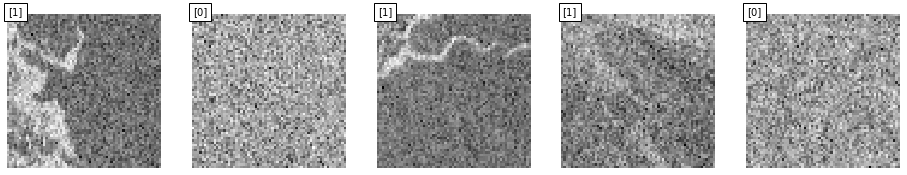

In [7]:
slices=5
plt.figure(figsize=(16,8))
for i in range(slices):
    plt.subplot(1, slices, i+1)
    plt.imshow(X_train[i, :,:,0], interpolation='nearest',cmap='gray')
    plt.text(0, 0, training_labels[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

   
    
    
    

In [8]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(training_labels, 10)
y_test = np_utils.to_categorical(test_labels, 10)

y_test.shape, X_test.shape

((7, 10), (7, 64, 64, 1))

In [9]:


def build_SimpNet(act='relu', cnn_drop_rate=0, fc_drop_rate=.5):
    # inputs
    radar_input, aux_input = get_inputs()
    
    
    # SimpNet CNN architecture
    x = Convolutional_block(x, 66, act, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 128, act, n_Conv=3, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 192, act, drop_rate=cnn_drop_rate)
    x = SAF_pooling(x)
    x = Convolutional_block(x, 192, act, n_Conv=4, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 288, act, drop_rate=cnn_drop_rate)
    x = SAF_pooling(x)
    x = Convolutional_block(x, 288, act, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 355, act, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 432, act, drop_rate=cnn_drop_rate)
    y = GlobalMaxPool2D()(x)
    
    # concatenate aux input
    combined = concatenate([radar_output, aux_input])
    
    # short FC layers
    x = Dense_block(combined, 1024, act, drop_rate=fc_drop_rate)
    x = Dense_block(x, 1024, act, drop_rate=fc_drop_rate)
    output = Dense(1, activation='sigmoid', name='is_iceberg')(x)
    
    # model definition and summary
    model = Model([radar_input, aux_input], output, name='SimpNet')
    model.summary()
    # plot_model(model, to_file='cnn-simpnet.png')
    
    return model



In [62]:
img_width = 64
img_height = 64
# Check for TensorFlow or Thieno
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
 

In [11]:

def cnn_model():
    model = Sequential()
    # Conv2D : Two dimenstional convulational model.
    # 32 : Input for next layer
    # (3,3) convulonational windows size
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) # Output convert into one dimension layer and will go to Dense layer
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', name='prediction'))

   
    

    return model
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

In [27]:
def cnn_model():
  
    
    model=Sequential()
    model.add(Conv2D(32, 3, activation='relu', input_shape=(64,64, 1), name='block1_conv1'))
    model.add(MaxPooling2D(pool_size=(2,2), name='block1_maxpool'))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', name='prediction'))
    
    return model
model = cnn_model()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 62, 62, 32)        320       
_________________________________________________________________
block1_maxpool (MaxPooling2D (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 30752)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               3936384   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
prediction (Dense)           (None, 10)                1290      
Total params: 3,937,994
Trainable params: 3,937,994
Non-trainable params: 0
___________________________________________

In [66]:
import tensorflow as tf
from d2l import tensorflow as d2l

def alexnet():
    model=Sequential()
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of
    # the output. Here, the number of output channels is much larger than
    # that in LeNet

        
    #model.add(Conv2D(filters=96, kernel_size=11, strides=4,
                          # activation='relu'),input_shape=(64,64, 1))
    model.add(Conv2D(32, 3, activation='relu', input_shape=(64,64, 1), name='block1_conv1'))

    model.add(MaxPooling2D(pool_size=3, strides=2))
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the
    # number of output channels
    model.add(Conv2D(filters=256, kernel_size=5, padding='same',
                           activation='relu'))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of
    # output channels is further increased. Pooling layers are not used to
    # reduce the height and width of input after the first two
    # convolutional layers
    model.add(Conv2D(filters=384, kernel_size=3, padding='same',
                           activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=3, padding='same',
                           activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=3, padding='same',
                           activation='relu'))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    model.add(Flatten())
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer. Since we are using Fashion-MNIST, the number of
    # classes is 10, instead of 1000 as in the paper
    model.add(Dense(10))
    model.summary()
    return model

model = alexnet()
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 30, 30, 256)       205056    
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 14, 14, 384)       885120    
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 14, 14, 384)       1327488   
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 14, 14, 256)     

In [46]:
model

In [67]:
from keras import optimizers

model = alexnet()
#model = vgg(conv_arch)
model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 30, 30, 256)       205056    
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 14, 14, 384)       885120    
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 14, 14, 384)       1327488   
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 14, 14, 256)     

In [68]:
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs = 30, 
                    shuffle = True,
                    verbose=1)


Epoch 1/30
22/22 [==============================] - 4s 180ms/step - loss: 8.9219 - accuracy: 0.5220
Epoch 2/30
22/22 [==============================] - 4s 176ms/step - loss: 8.2892 - accuracy: 0.5143
Epoch 3/30
22/22 [==============================] - 4s 177ms/step - loss: 10.8534 - accuracy: 0.6734
Epoch 4/30
22/22 [==============================] - 4s 178ms/step - loss: 12.5957 - accuracy: 0.7815
Epoch 5/30
22/22 [==============================] - 4s 167ms/step - loss: 11.3854 - accuracy: 0.7064
Epoch 6/30
22/22 [==============================] - 4s 175ms/step - loss: 9.4204 - accuracy: 0.5845
Epoch 7/30
22/22 [==============================] - 4s 171ms/step - loss: 6.6917 - accuracy: 0.4152
Epoch 8/30
22/22 [==============================] - 4s 179ms/step - loss: 6.0949 - accuracy: 0.3781
Epoch 9/30
22/22 [==============================] - 4s 178ms/step - loss: 7.4262 - accuracy: 0.4607
Epoch 10/30
22/22 [==============================] - 4s 172ms/step - loss: 10.5950 - accuracy: 0.

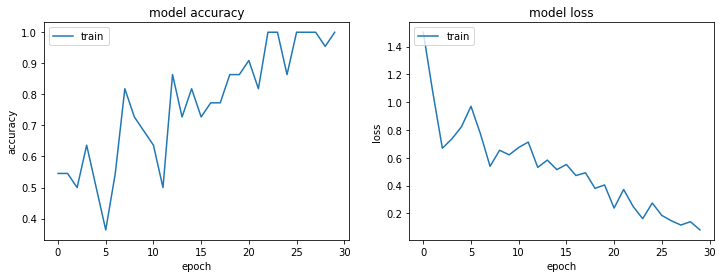

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('{} : {}, {} : {}'.format(model.metrics_names[0],score[0], model.metrics_names[1], score[1]))

loss : 0.36500316858291626, accuracy : 0.8571428656578064


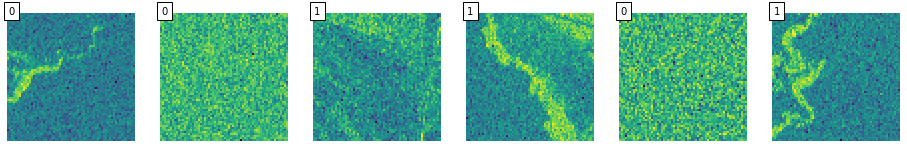

In [32]:
slices = 6
predicted = model.predict(X_test[:slices]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slices):
    plt.subplot(1, slices, i+1)
    plt.imshow(X_test[i, :,:,0], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

In [33]:
predicted = model.predict(X_test).argmax(-1)



In [34]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [36]:
class LULC(enum.Enum):
    CW        = (0,  'CW',            'white')
    WH    = (1,  ' WH','xkcd:lime')
           
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3   
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 2, 1), lulc_cmap.N)



Kappa coeff. 0.696
Classification accuracy 85.7%
Classification F1-score 86.3%
             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * CW                   = 80.0 |  100.0  | 66.7
         *  WH                  = 88.9 |  80.0  | 100.0


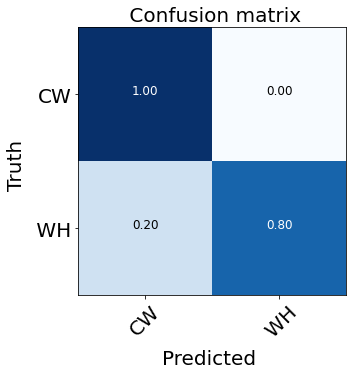

In [37]:
fig = plt.figure(figsize=(5,5))
conf_matrix_gbm = metrics.confusion_matrix(test_labels,predicted)
class_names = [entry.class_name for entry in LULC]
class_labels = np.unique(test_labels)




plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth ', 
                      xlabel='Predicted ',
                      title=' Confusion matrix');

print('Kappa coeff. {:.3f}'.format( cohen_kappa_score(test_labels,predicted)))

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(test_labels,predicted)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(test_labels,predicted, average='weighted')))

f1_scores = metrics.f1_score(test_labels,predicted, labels=class_labels, average=None)
recall = metrics.recall_score(test_labels,predicted, labels=class_labels, average=None)
precision = metrics.precision_score(test_labels,predicted, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

In [38]:
for it, mod in enumerate(model.layers):
    print('Layer no: {}, name: {}'.format(it, mod.name))

Layer no: 0, name: block1_conv1
Layer no: 1, name: block1_maxpool
Layer no: 2, name: flatten_8
Layer no: 3, name: fc1
Layer no: 4, name: dropout_11
Layer no: 5, name: prediction


In [39]:
import keras.backend as K
def get_activations(model, layer, input_img_data):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((input_img_data, False))
    return activations

In [40]:
X_test.shape

(7, 64, 64, 1)

In [41]:
def val(valloader, model, optimizer, label_type, epoch, use_cuda, val_writer):

    prec_score_ = Precision_score()
    recal_score_ = Recall_score()
    f1_score_ = F1_score()
    f2_score_ = F2_score()
    hamming_loss_ = Hamming_loss()
    subset_acc_ = Subset_accuracy()
    acc_score_ = Accuracy_score()
    one_err_ = One_error()
    coverage_err_ = Coverage_error()
    rank_loss_ = Ranking_loss()
    labelAvgPrec_score_ = LabelAvgPrec_score()

    # set model to evaluation mode
    model.eval()
    
    # main validation loop
    y_true = []
    predicted_probs = []

    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(valloader, desc="validation")):

            # unpack sample
            bands = data["image"]
            labels = data["label"]
    
            # move data to gpu if model is on gpu
            if use_cuda:
                bands = bands.to(torch.device("cuda"))
                #labels = labels.to(torch.device("cuda"))
            
            # forward pass 
            logits = model(bands)
            
            # convert logits to probabilies
            if label_type == 'multi_label':
                probs = torch.sigmoid(logits).cpu().numpy()
            else:
                sm = torch.nn.Softmax(dim=1)
                probs = sm(logits).cpu().numpy()
                  
            labels = labels.cpu().numpy() # keep true & pred label at same loc.
            predicted_probs += list(probs)
            y_true += list(labels)
            
        
    predicted_probs = np.asarray(predicted_probs)
    # convert predicted probabilities into one/multi-hot labels 
    if label_type == 'multi_label':
        y_predicted = (predicted_probs >= 0.5).astype(np.float32)
    else:
        loc = np.argmax(predicted_probs, axis=-1)
        y_predicted = np.zeros_like(predicted_probs).astype(np.float32)
        for i in range(len(loc)):
            y_predicted[i,loc[i]] = 1
        
    y_true = np.asarray(y_true)
    

    macro_f1, micro_f1, sample_f1 = f1_score_(y_predicted, y_true)
    macro_f2, micro_f2, sample_f2 = f2_score_(y_predicted, y_true)
    macro_prec, micro_prec, sample_prec = prec_score_(y_predicted, y_true)
    macro_rec, micro_rec, sample_rec = recal_score_(y_predicted, y_true)
    hamming_loss = hamming_loss_(y_predicted, y_true)
    subset_acc = subset_acc_(y_predicted, y_true)
    macro_acc, micro_acc, sample_acc = acc_score_(y_predicted, y_true)

    # Note that below 4 ranking-based metrics are not applicable to single-label
    # (multi-class) classification, but they will still show the scores during 
    # validation on tensorboard
    one_error = one_err_(predicted_probs, y_true)
    coverage_error = coverage_err_(predicted_probs, y_true)
    rank_loss = rank_loss_(predicted_probs, y_true)
    labelAvgPrec = labelAvgPrec_score_(predicted_probs, y_true)

    info = {
            "macroPrec" : macro_prec,
            "microPrec" : micro_prec,
            "samplePrec" : sample_prec,
            "macroRec" : macro_rec,
            "microRec" : micro_rec,
            "sampleRec" : sample_rec,
            "macroF1" : macro_f1,
            "microF1" : micro_f1,
            "sampleF1" : sample_f1,
            "macroF2" : macro_f2,
            "microF2" : micro_f2,
            "sampleF2" : sample_f2,
            "HammingLoss" : hamming_loss,
            "subsetAcc" : subset_acc,
            "macroAcc" : macro_acc,
            "microAcc" : micro_acc,
            "sampleAcc" : sample_acc,
            "oneError" : one_error,
            "coverageError" : coverage_error,
            "rankLoss" : rank_loss,
            "labelAvgPrec" : labelAvgPrec
            }

    for tag, value in info.items():
        val_writer.add_scalar(tag, value, epoch)

    print('Validation microPrec: {:.6f} microF1: {:.6f} sampleF1: {:.6f} microF2: {:.6f} sampleF2: {:.6f}'.format(
            micro_prec,
            micro_f1,
            sample_f1,
            micro_f2,
            sample_f2
            ))
    return micro_f1
